# Fake News Classification

Brief:  
This notebook builds a classification model to distinguish between fake and real news articles. It includes:

- Reading the dataset and performing EDA (Exploratory Data Analysis) to explore class distribution and text characteristics.  
- Preprocessing the news titles and text (removing stopwords, lemmatization, and vectorization).  
- Visualizing common terms in fake vs. real news articles using word clouds.
- Training a Logistic Regression classifier to predict whether a news article is fake or real.  
- Evaluating the model using accuracy and F1-score.  
  

Tools used: Pandas, NLTK/spaCy, Scikit-learn, Matplotlib/Seaborn, and WordCloud.  


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

In [ ]:
plt.style.use('seaborn-v0_8')
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

### Data Reading & EDA

In [ ]:
fake_df = pd.read_csv('Fake.csv')
true_df = pd.read_csv('True.csv')

In [ ]:
fake_df['label'] = 0
true_df['label'] = 1
data = pd.concat([fake_df, true_df], ignore_index=True)
data.sample(3)

,title,text,subject,date,label
833,Trump And Putin Had A Secret Meeting After Th...,Donald Trump said after his official meeting w...,News,"July 18, 2017",0
10569,WHOA! HEATHER NAUERT Gets Into Testy Exchange ...,What in the world is wrong with these press pe...,politics,"Jun 20, 2017",0
28118,Senator seeks ethics probe of Mnuchin's 'Lego ...,WASHINGTON (Reuters) - The top Democrat on the...,politicsNews,"March 28, 2017",1


In [ ]:
data['content'] = data['title'] + ' ' + data['text'] # conbining title with text in one column 
data.drop(columns=['title', 'text', 'subject', 'date'], inplace=True)
data.sample(3)

,label,content
34074,1,"Hecklers disrupt Trump rally, photographer sho..."
3452,0,Nate Silver’s Election Autopsy And Reason For...
20524,0,BLACK CONSERVATIVE Student DESTROYS Black Live...


In [ ]:
data.shape

(44898, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    44898 non-null  int64 
 1   content  44898 non-null  object
dtypes: int64(1), object(1)
memory usage: 701.7+ KB


In [ ]:
data.isnull().sum()

,0
label,0
content,0


In [ ]:
duplicates = data[data['content'].duplicated(keep=False)]
duplicates = duplicates.sort_values(by="content")
duplicates

,label,content
20771,0,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...
14160,0,#AnyoneButHillary: NEW POLL Shows Bernie Suppo...
9841,0,#Austin: Fights Break Out Between Police and S...
17930,0,#Austin: Fights Break Out Between Police and S...
11756,0,#Berkeley CRAZY! RIOTERS CHASE And Beat People...
...,...,...
19149,0,“Would You Rather Do A Job You Hate And Not Pa...
16696,0,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...
14235,0,“YOU’RE HIRED!” Trump Pulls Unemployed Vet Fro...
21428,0,“You’re Not Welcome!” Obama As Welcome At Rose...


In [ ]:
data.drop_duplicates(subset='content', keep='first', inplace=True)
data['content'].duplicated().sum()

np.int64(0)

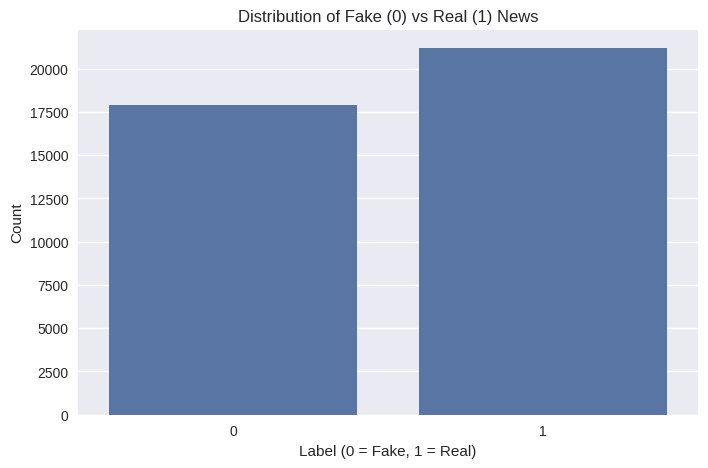

In [ ]:
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=data)
plt.title('Distribution of Fake (0) vs Real (1) News')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Count')
plt.show()

In [ ]:
data['content_length'] = data['content'].str.len()
print("\nSummary statistics for content length:")
print(data['content_length'].describe())


Summary statistics for content length:
count    39105.000000
mean      2505.880629
std       1943.950515
min         31.000000
25%       1348.000000
50%       2288.000000
75%       3163.000000
max      51893.000000
Name: content_length, dtype: float64


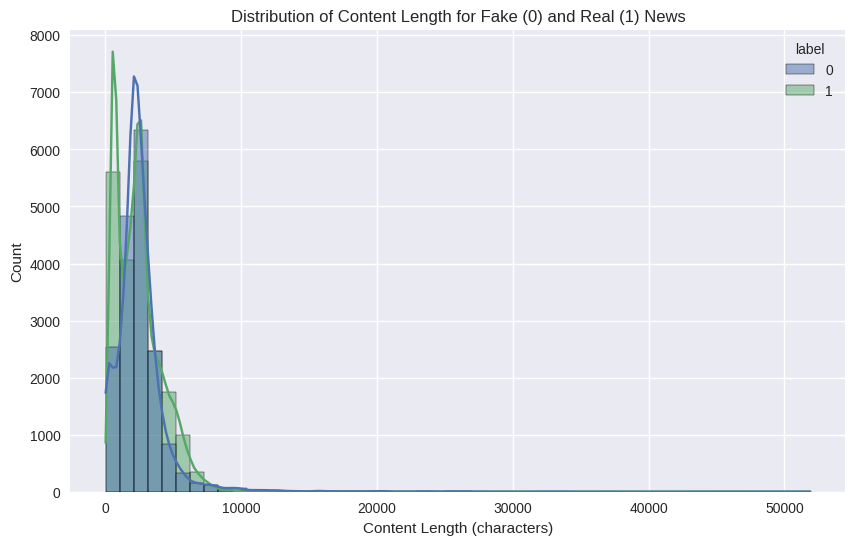

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(data=data, x='content_length', hue='label', bins=50, kde=True)
plt.title('Distribution of Content Length for Fake and Real News')
plt.xlabel('Content Length (characters)')
plt.ylabel('Count')
plt.show()

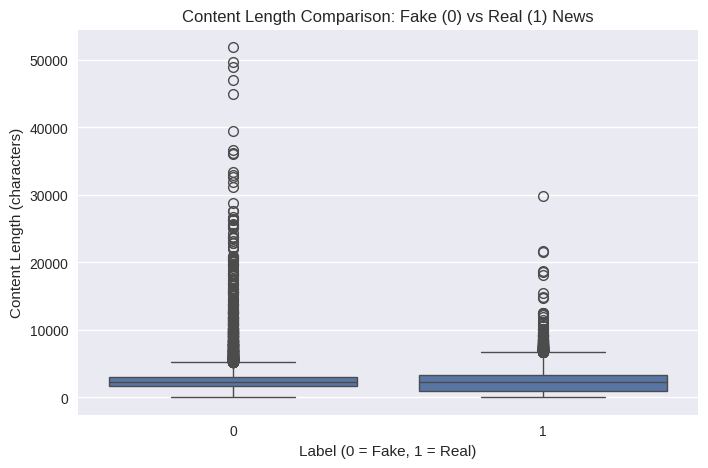

In [ ]:
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='content_length', data=data)
plt.title('Content Length Comparison: Fake (0) vs Real (1) News')
plt.xlabel('Label (0 = Fake, 1 = Real)')
plt.ylabel('Content Length (characters)')
plt.show()

In [ ]:
data.drop(columns=['content_length'], inplace=True)

**Text Preprocessing and vectorization**

In [ ]:
def preprocess_text(text):
    # non-ASCII chars, it won't be useful
    text = text.encode('ascii', 'ignore').decode('ascii')

    text = text.lower()

    text = re.sub(r'[^a-zA-Z\s]', ' ', text)

    tokens = word_tokenize(text)

    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    processed_text = ' '.join(tokens)

    return processed_text

In [ ]:
data['content'] = data['content'].apply(preprocess_text)
data.sample(3)

,label,content
22459,0,cover new detail orlando shooter crisis call c...
25327,1,house conservative group line trump deal debt ...
8801,0,bundy militia loses bag k video last week soci...


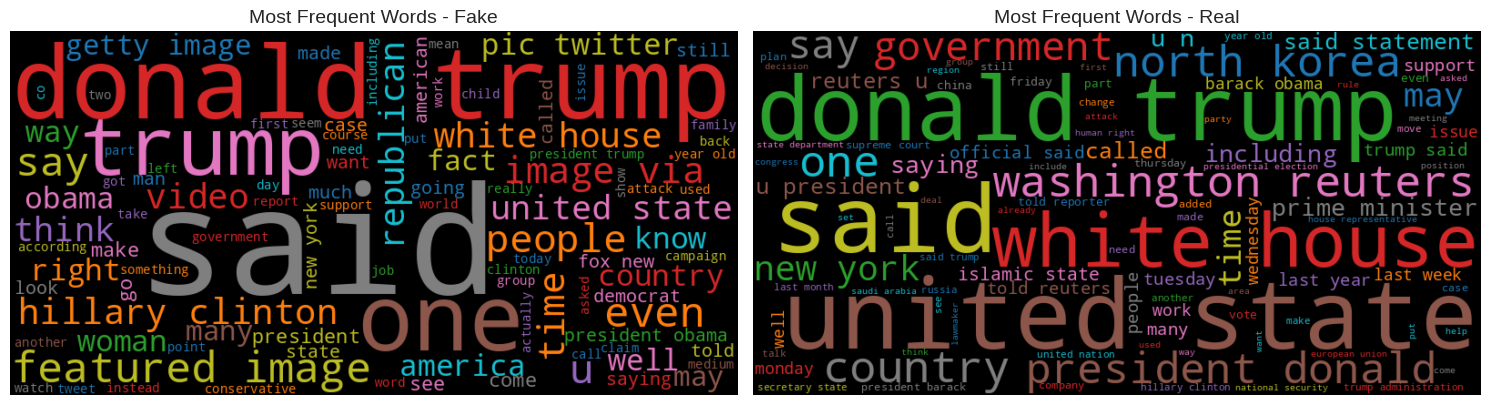

In [ ]:
labels = [0, 1]
labels_names = {0: 'Fake', 1: 'Real'}

plt.figure(figsize=(15, 5))

for i, label in enumerate(labels, 1):
    text = ' '.join(data[data['label'] == label]['content'])
    wc = WordCloud(width=800, height=400, background_color='black', max_words=100, colormap='tab10').generate(text)

    plt.subplot(1, 2, i)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Most Frequent Words - {labels_names[label]}', fontsize=14)

plt.tight_layout()
plt.show()


In [ ]:
# data.to_csv('cleand_data.csv', index=False)
# print("\nDataFrame successfully saved to 'cleand_data.csv'")


DataFrame successfully saved to 'cleaned_data.csv'


In [ ]:
vectorizer = TfidfVectorizer(max_features=10000 ,ngram_range=(1, 3), stop_words='english')
X = vectorizer.fit_transform(data['content'])
y = data['label']

**Model Training**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [ ]:
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [25]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score (weighted): {f1:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Fake', 'Real']))


Accuracy: 0.9886
F1-Score (weighted): 0.9886

Classification Report:
              precision    recall  f1-score   support

        Fake       0.99      0.98      0.99      4477
        Real       0.98      0.99      0.99      5300

    accuracy                           0.99      9777
   macro avg       0.99      0.99      0.99      9777
weighted avg       0.99      0.99      0.99      9777



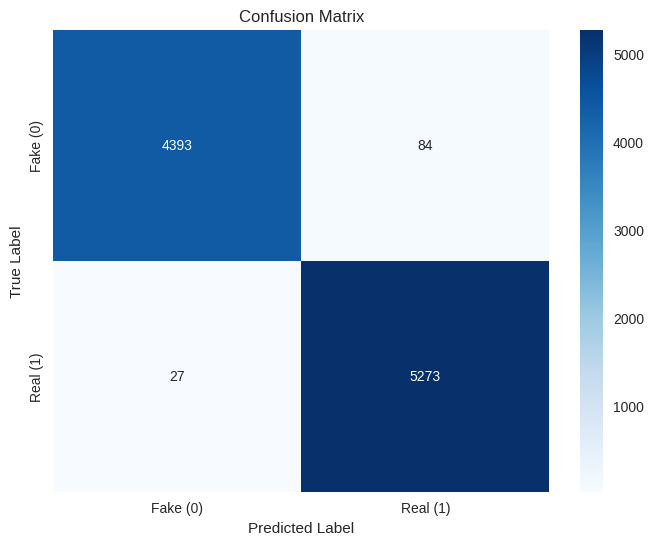

In [26]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake (0)', 'Real (1)'], yticklabels=['Fake (0)', 'Real (1)'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Test on user input

In [27]:
def predict_news(title_and_text):
    processed_input = preprocess_text(title_and_text)
    input_vector = vectorizer.transform([processed_input])
    prediction = clf.predict(input_vector)[0]
    return "Real New" if prediction == 1 else "Fake New"

In [28]:
user_input = input("Enter the news title and text (combined): ")

result = predict_news(user_input)
print(f"Prediction: {result}")

Enter the news title and text (combined): First round of bilateral dialogue between Egypt, Japan on international legal issues held CAIRO – 12 September 2025: Egypt’s Ministry of Foreign Affairs, Emigration hosted the inaugural round of bilateral dialogue between Egypt and Japan on international legal issues of mutual concern.     The Japanese delegation was led by Mr. Nakamura Kazuhiko, Legal Advisor at the International Legal Affairs Bureau of the Japanese Ministry of Foreign Affairs. The Egyptian side was headed by Ambassador Hatem Abdel Qader, Assistant Minister of Foreign Affairs for International Legal Affairs and Treaties.     The discussions encompassed a wide range of current political and legal matters. The Egyptian delegation presented its national legal perspective on the ongoing Israeli war in the Gaza Strip, emphasizing Israel’s responsibilities as an occupying power under the provisions of the Four Geneva Conventions on International Humanitarian Law. The Egyptian side a

# End

Author: Omar Atef Ahmed

Task: Third Task - Fake News Detection

GitHub: https://github.com/k8onl

LinkedIn: https://www.linkedin.com/in/k8onl
